# DAY 4: Classification - models and evaluation

### Machine Learning and Computational Statistics (DSC6232)

#### Instructors: Weiwei Pan, Melanie Fernandez, Pavlos Protopapas

#### Due: June 9th, 2:00 pm Kigali Time

**First name**: DUSENGEYEZU


**Last name**: LONGIN

**ID**:22020609


## Learning Goals:

1. train logistic regression with linear and polynomial boundaries
2. understand the problem of class imbalance in classification
3. identify the appropriate evaluation metrics for real-life problems
4. compute the accuracy and confusion matrix

### Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp

#import data processing
from sklearn.model_selection import train_test_split

#import models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest

#import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

#import visualization libraries
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Auxiliary functions to generate and visualize data. 
**No need to read through!**

In [ ]:
def make_toy_data():
    '''
    make_toy_data generates synthetic data for the cancer classification task.
    
    input: None
    returns: 
       x_train - an numpy array of size 737 x 2, each row is a patient, each column is a biomarker
       x_test - an numpy array of size 363 x 2, each row is a patient, each column is a biomarker
       y_train - an numpy array of length 737, each entry is either 0 (no cancer) or 1 (cancerous)
       y_test - an numpy array of length 363, each entry is either 0 (no cancer) or 1 (cancerous)
    '''
    
    class_0_size = 1000
    mu_0 = np.array([10, 15])
    Sigma_0 = np.array([[50, -30], 
                        [-30, 80]])
    class_0 = np.random.multivariate_normal(mu_0, Sigma_0, size=class_0_size)

    class_1_size = 100
    mu_1 = np.array([22, 6])
    Sigma_1 = np.array([[20, 5], 
                        [5, 20]])
    class_1 = np.random.multivariate_normal(mu_1, Sigma_1, size=class_1_size)
    
    x = np.vstack((class_0, class_1))
    y = np.hstack((np.zeros(class_0_size), np.ones(class_1_size)))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    return x_train, x_test, y_train, y_test

def scatter_plot_data(x, y, ax):
    '''
    scatter_plot_data scatter plots the patient data. A point in the plot is colored 'red' if cancerous 
    and blue otherwise.
    
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       ax - axis to plot on
    returns: 
       ax - the axis with the scatter plot
    '''
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    ax.set_xlim((-20, 40))
    ax.set_ylim((-20, 40))
    ax.set_xlabel('marker 1')
    ax.set_ylabel('marker 2')
    ax.legend(loc='best')
    return ax

def plot_decision_boundary(x, y, model, ax=None, plot_boundary_only=False, poly_degree=1):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a location, each column is a coordinate
       y - a numpy array of length N, each entry is either 0 (non-vegetation) or 1 (vegetation)
       model - the 'sklearn' classification model
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
    returns: 
       ax - the axis with the scatter plot
    
    '''
    if ax is None: f, ax = plt.subplots()

    # Plot data
    if not plot_boundary_only:
        ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='cancer')
        ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='healthy')
    
    # Create mesh
    interval = np.arange(-20,40,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree)
        xx = polynomial_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if not plot_boundary_only:
        ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    ax.contour(x1, x2, yy, colors='black', linewidths=0.1)
    ax.set_xlim([-20, 40])
    ax.set_ylim([-20, 40])
    ax.set_xlabel('Marker 1')
    ax.set_ylabel('Marker 2')
    ax.legend(loc='best')
    return ax

## Introduction: Cancer Diagnosis Based on Biopsy Markers

In this problem, we want to classify whether or not a patient has a rare and aggressive type of skin cancer based on two biomarkers extracted from biopsies of skin samples.

In the lectures, we have seen that:
1. ***accuracy*** is a bad metric (even terribles models can have 100% accuracy simply due to class imbalance).

2. visualizing the ***decision boundary*** of a classifier is a better way to evaluate model performance, but it is not possible to visualize most real-datasets (due to the large number of features).

2. the ***confusion matrix*** is a better way to assess the performance of classifiers, but we still prefer a single number to summarize aspects of the matrix that we care about.

**Instructions**: run the code below to make a toy training and testing classification data set and visualize the data.

We generate toy data for this application. `x` is a an array where each row represents a patient and each column represents a biomarker. `y` is an array of `0`'s and `1`'s, where `0` indicates absence of cancer and `1` indicates presence of cancer.

In [ ]:
# generate toy data
x_train, x_test, y_train, y_test = make_toy_data()

print('Number of patients:', x_train.shape[0])
print('Number of features:', x_train.shape[1])


Number of patients: 737
Number of features: 2


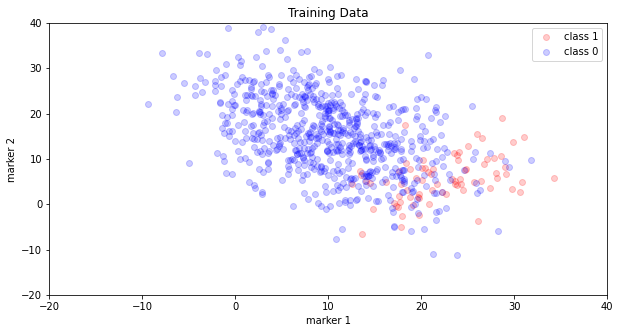

In [ ]:
# visualize the toy data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
scatter_plot_data(x_train, y_train, ax)
ax.set_title('Training Data')
plt.show()

## 1. Logistic regression

We first fit a logistic regression model to this dataset using a **linear** decision boundary and evaluate its performance.

**Exercise 1:** Use `sklearn`'s `LogisticRegression` model to fit a logistic regression classifier and plot its decision boundary using `plot_decision_boundary`.

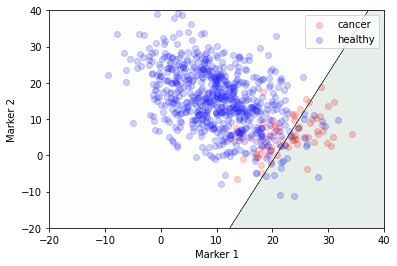

In [ ]:
# Fit a logistic regression classifier
# and plot decision boundary
#
# Hint: you may want to look at this for reference about sklearn's logistic regression classifier: 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#
# COMPLETE
# Step 1: Instantiate a sklearn LogisticRegression model
logistic = LogisticRegression()
# 
# Step 2: Fit the model to our training dataset
trained_logistic=logistic.fit(x_train,y_train)
# Step 3: Plot the decision boundary using the `plot_decision_boundary` function
#plot_decision_boundary(x, y, model, ax=None, plot_boundary_only=False, poly_degree=1):
plot_decision_boundary(x_train,y_train,trained_logistic)

**Exercise 2:** Use your model's `.score()` function to compute the overall accuracy of your classifier. Then, use `sklearn`'s `plot_confusion_matrix` to visualize the confusion matrix of our logistic regression classifier.

In [ ]:
# Step 1: compute the accuracy of your classifer using the .score() function
# Hint:  you may want to look at this for reference
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score
#
y_pred=trained_logistic.predict(x_test)
test_accuracy =trained_logistic.score(x_test, y_test)
train_accuracy =trained_logistic.score(x_train,y_train)
print('The train accuracy is: {}, The test accuracy is: {}'.format(train_accuracy, test_accuracy))

The train accuracy is: 0.9131614654002713, The test accuracy is: 0.9090909090909091


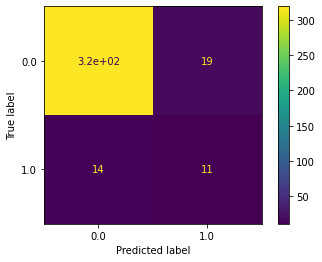

In [ ]:
# Step 2: plot confusion matrix
#
# Hint: you may want to look at this for reference
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
#
# COMPLETE
plot_confusion_matrix(trained_logistic, x_test, y_test)  
plt.show()

**Exercise 3:** Interpret the parameters of this model, which biomarker (marker 1 or 2) has a bigger impact on the probability of being classified as positive for cancer?

In [ ]:
# Step 1: print out the parameters of your logistic regression model using the .coef_ attribute of your model
# Hint:  you may want to look for a description of the .coef_ attribute here
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#
# COMPLETE
print(trained_logistic.coef_)

[[ 0.28579132 -0.1181141 ]]


**Answer**: 
By using parameter interpretation you can say that marker 1 has great impact on the prediction,  increasing it we are getting chance of having cancer if decreased   chance of getting cancer will reduced.


**Exercise 4:** Is this a good classifier for our data set? Why or why not? Support your answer with analysis of the accuracy, the confusion matrix and your visualization of the decision boundary. Your answer must also address the real life consequences of using this classifier on actual patients.


**Answer**: 
By looking at accuracy of this model you can say that it is good, but we have seen that from scatter plot class without cancer is dominate class this Couse as to do not consider it in drawing conclusion
Because accuracy is potentially misleading as an evaluation metric because it averages the model performance on the majority class with its performance on the minority class. This allows good performance on the large class to obscure the poor performance on the small class.
This could Couse us to look on confusion matrix and we have seen it has poor performance on classifying same people as suffering by cancer (7) while is not and 13 people as no cancer while they have, and this is terrible  in domain of health. This could not be a good model to be used because it could confuse decision makers in their decisions. Also this can be verified we we look at model boundary.




**Exercise 5:** Instead of classifying rare diseases, imagine that this classifier is being used to detect if students are cheating on an exam, with class 0 representing students who did not cheat and class 1 representing students who cheated. If a student is predicted by this model to have cheated then he or she may be expelled. 

Discuss whether or nor the above classifier is appropriate for this cheating application. Support your answer with analysis of the accuracy, the confusion matrix and your visualization of the decision boundary. Your answer must also address the real life consequences of using this classifier on actual students.

**Answer**: If this model is changed to be cheating application,
Because accuracy is potentially misleading as an evaluation metric because it averages the model performance on the majority class with its performance on the minority class. This allows good performance on the large class to obscure the poor performance on the small class.
This could Couse us to look on confusion matrix and we have seen it has poor performance on classifying same student as innocent (7) while is not and 13 student as cheated while they are innocent, and this is terrible in domain of education. This could not be a good model to be used because it could confuse decision makers in their decisions. Also this can be verified we we look at model boundary.


## 2. Logistic regression with polynomial boundary

We now fit a logistic regression model to this dataset using a **polynomial** decision boundary and evaluate its performance.

**Exercise 6:** Use `sklearn`'s `LogisticRegression` model to fit a logistic regression classifier and plot its decision boundary using `plot_decision_boundary`. What is the best degree for the polynomial decision boundary? Why?

**Answer**: 
a.	By using different model with various degree of freedom [2,3,4,5,6],so by observing on the accuracy of each model you can say that all model are best since all accuracy is closer to 1.
But when observe on confusion matrix and parameter it becomes other story from accuracy.  Because all models have high rate of wrong classification each class.
Now let us analyze based on boundary visualization in all model I can choose model with degree of freedom of 2. Because even it is not perfect but is the one which is best in all remaining model.   


The train accuracy on :2, is : 0.9253731343283582, The test accuracy is: 0.931129476584022


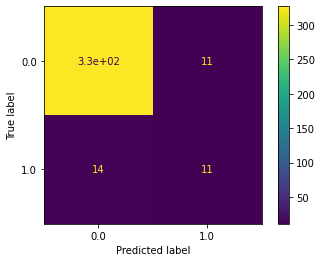

The train accuracy on :3, is : 0.9240162822252375, The test accuracy is: 0.9228650137741047


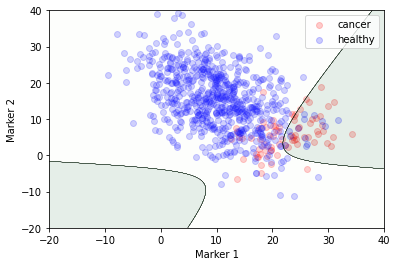

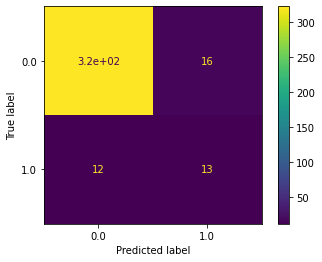

The train accuracy on :4, is : 0.9240162822252375, The test accuracy is: 0.9228650137741047


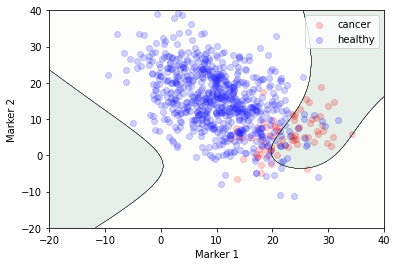

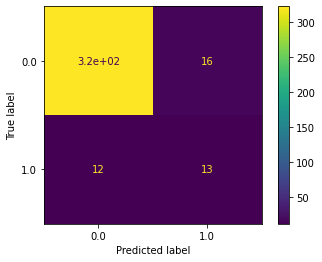

The train accuracy on :5, is : 0.9240162822252375, The test accuracy is: 0.928374655647383


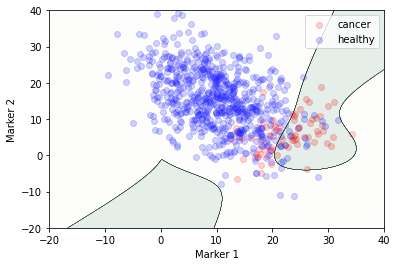

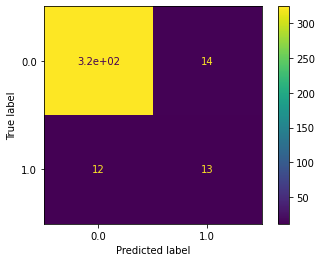

The train accuracy on :6, is : 0.9280868385345997, The test accuracy is: 0.9228650137741047


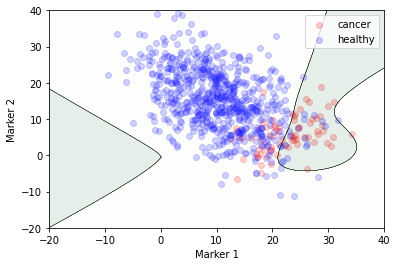

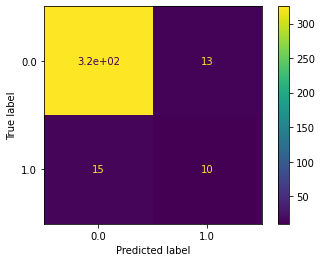

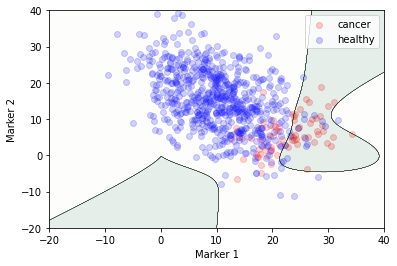

In [ ]:
degrees = [2,3,4,5,6]
#f, axs = plt.subplots(1,len(degrees),figsize=(5*len(degrees),5))

trained_models = []
transformed_test_data = []
for idx, degree in enumerate(degrees):
  # Step 1: transform your training and testing data into polynomial features
  # using sklearn's PolynomialFeatures
  degree_of_polynomial = degree
  polynomial_features = PolynomialFeatures(degree_of_polynomial) # instantiate PolynomialFeatures
  polynomial_features.fit(x_train) # fit on our training iput
  x_train_poly = polynomial_features.transform(x_train) # add polynomial powers to our training input 
  x_test_poly = polynomial_features.transform(x_test)# add polynomial powers to our test input

  # Step 2: instantiate a LogisticRegression model
  logistic_poly = LogisticRegression(max_iter=100000, fit_intercept=False)
# Step 3: fit this model to our training data
  logistic_poly.fit(x_train_poly,y_train)

  # Step 4: plot the decision boundary of this model
  y_pred=logistic_poly.predict(x_test_poly)
  test_accuracy =logistic_poly.score(x_test_poly, y_test)
  train_accuracy =logistic_poly.score(x_train_poly,y_train)
  print('The train accuracy on :{}, is : {}, The test accuracy is: {}'.format(degree,train_accuracy, test_accuracy))
  
  #print('The coeficience on :{}, is : {}'.format(degree,logistic_poly.coef_))
  plot_confusion_matrix(logistic_poly, x_test_poly, y_test)  
  plt.show()
  plot_decision_boundary(x_train, y_train, logistic_poly, poly_degree=degree_of_polynomial)
  


The train accuracy on :6, is : 0.9280868385345997, The test accuracy is: 0.9228650137741047
The coeficience on :6, is : [[-1.95116738e-08 -1.73515668e-07 -9.74887146e-08 -1.69853371e-06
  -7.93747657e-07 -5.77778027e-07 -1.51701458e-05 -6.78324755e-06
  -3.74841864e-06 -3.53153635e-06 -9.67991172e-05 -4.21236672e-05
  -2.04322858e-05 -1.57480441e-05 -1.63239630e-05  7.05998376e-06
   2.40798246e-06  1.24139428e-05 -1.65180788e-05  1.03098949e-05
  -2.74768813e-05 -1.16955231e-07 -3.79699078e-08 -6.76238602e-07
   1.55263403e-06 -1.66380045e-06  1.93570901e-06 -2.57677986e-07]]


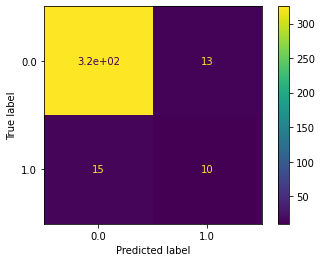

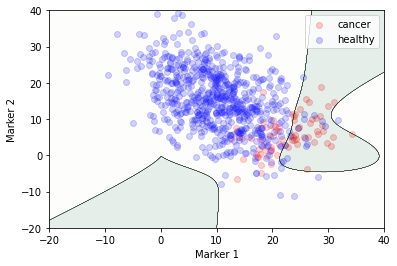

In [ ]:
degrees =2
#f, axs = plt.subplots(1,len(degrees),figsize=(5*len(degrees),5))

trained_models = []
transformed_test_data = []
# Step 1: transform your training and testing data into polynomial features
  # using sklearn's PolynomialFeatures
degree_of_polynomial = degree
polynomial_features = PolynomialFeatures(degree_of_polynomial) # instantiate PolynomialFeatures
polynomial_features.fit(x_train) # fit on our training iput
x_train_poly = polynomial_features.transform(x_train) # add polynomial powers to our training input 
x_test_poly = polynomial_features.transform(x_test)# add polynomial powers to our test input

  # Step 2: instantiate a LogisticRegression model
logistic_poly = LogisticRegression(max_iter=100000, fit_intercept=False)
# Step 3: fit this model to our training data
logistic_poly.fit(x_train_poly,y_train)

  # Step 4: plot the decision boundary of this model
y_pred=logistic_poly.predict(x_test_poly)
test_accuracy =logistic_poly.score(x_test_poly, y_test)
train_accuracy =logistic_poly.score(x_train_poly,y_train)
print('The train accuracy on :{}, is : {}, The test accuracy is: {}'.format(degree,train_accuracy, test_accuracy))
  
print('The coeficience on :{}, is : {}'.format(degree,logistic_poly.coef_))
plot_confusion_matrix(logistic_poly, x_test_poly, y_test)  
plt.show()
plot_decision_boundary(x_train, y_train, logistic_poly, poly_degree=degree_of_polynomial)
  
  


**Exercise 7:** If you printed out the parameters of this logistic regression model with polynomial decision boundary, would you be able to conclude which covariate (marker 1 or 2) has a bigger impact on the chances of being classified with cancer (class 1)?

**Answer**: When you print out model with 2 as degree of freedom, we cannot say which covariate (marker 1or 2 ) has a bigger impact on the chances of being classified with cancer (class 1)?
Because both covariate are intertwined and it is hard to analyze 


**Exercise 8:** Is this a good classifier for our data set? Why or why not? Support your answer with analysis of the accuracy, the confusion matrix and your visualization of the decision boundary. Your answer must also address the real life consequences of using this classifier on actual patients.


**Answer**:For this polynomial logistic classification with degree of 2 as degree for freedom, By looking at accuracy of this model you can say that it is good, but we have seen that from scatter plot class without cancer is dominate class this Couse as to do not consider it in drawing conclusion
Because accuracy is potentially misleading as an evaluation metric because it averages the model performance on the majority class with its performance on the minority class. This allows good performance on the large class to obscure the poor performance on the small class.
This could Couse us to look on confusion matrix and we have seen it has poor performance on classifying same people as suffering by cancer (13) while is not and 15 people as no cancer while they have, and this is terrible  in domain of health. This could not be a good model to be used because it could confuse decision makers in their decisions. Also this can be verified when we look at model boundary you can observe there is same red point which is not in boundary this means that same personnel with cancer are classified as normal personal and same sick personnel are classified as cancer free. This lead us to reject this model.    

